In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, LogLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import os
import cooltools.lib.plotting
import cooler
import bioframe

In [47]:
def format_ticks(ax, x=True, y=True, rotate=True, unit='b'):
    if unit == 'b':
        div = 1
    elif unit == 'kb':
        div = 1000
    elif unit == 'Mb':
        div = 100_000
    
    bp_formatter = FuncFormatter(lambda x, pos: f'{int(x * bin_size // div)} {unit}')
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    else:
        ax.yaxis.set_ticks([])
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    else:
        ax.xaxis.set_ticks([])
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [48]:
def open_cooler(path, resolution):
    ext = os.path.splitext(path)[1]
    if ext == '.cool':
        return cooler.Cooler(path)
    elif ext == '.mcool':
        return cooler.Cooler('::/resolutions/'.join((path, str(resolution))))
    else:
        raise TypeError('Provided file is not of required .cool or .mcool type.')

In [49]:
def get_contact_map(clr, balanced, start=None, end=None):
    if start is None or end is None:
        return clr.matrix(balance=balanced)[:]
    else:
        return clr.matrix(balance=balanced)[start:end, start:end]
        
def get_centromeres(centromeres_path, assembly):
    if centromeres_path:
        centromeres = pd.read_csv(centromeres_path, delim_whitespace=True, header=None, names=['chrom', 'start', 'end', 'mid'])
        centromeres['mid'] = centromeres.apply(lambda row: (row['start'] + row['end']) // 2, axis=1)
    else:
        centromeres = bioframe.fetch_centromeres(assembly)

    return centromeres

In [50]:
def format_chrom_labels(ax, chrom_names, chrom_positions, centromeres, plot_labels):
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    x_trans = ax.get_xaxis_transform()
    y_trans = ax.get_yaxis_transform()

    cmap = cm.summer(np.linspace(0, 1, len(chrom_names) * 2))

    pad = 10

    for i, (chrom, (start, end)) in enumerate(zip(chrom_names, chrom_positions)):
        if plot_labels:
            # plot axis labels
            ax.annotate(chrom, xy=((start + end) // 2, 1.037), xycoords=x_trans, ha='center', va='bottom')
            ax.annotate(chrom, xy=(-0.037, (start + end) // 2), xycoords=y_trans, ha='right', va='center', rotation=90)

        # plot label bars
        ax.plot([start + pad, end - pad], [1.02, 1.02], color=cmap[i], transform=x_trans, lw=7, clip_on=False)
        ax.plot([-0.02, -0.02], [start + pad, end - pad], color=cmap[i], transform=y_trans, lw=7, clip_on=False)

        # plot centromere positions
        ax.plot(start + centromeres[chrom], 1.02, transform=x_trans, color='black', marker='o', markersize=6, clip_on=False)
        ax.plot(-0.02, start + centromeres[chrom], transform=y_trans, color='black', marker='o', markersize=6, clip_on=False)

In [51]:
file_path = '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/200828_HiC_574_cdc20tdtop2tdscc173_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool'
file_paths = [
    '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/200828_HiC_574_cdc20tdtop2tdscc173_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool',
    '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/190425_HiC_938_cdc20td_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool'
]
cens_path = '/groups/goloborodko/genomepy/sacCer3/sacCer3.centromeres'
out_path = '/users/emma.rusch/hiC/out/maps/test.png'
resolution = 2000
region=('chrX', 'chrXI')
title = 'M phase'
ratio = True

In [52]:
centromeres = get_centromeres(cens_path, 'sacCer3')

if ratio:
    clr1 = open_cooler(file_paths[0], resolution)
    clr2 = open_cooler(file_paths[1], resolution)

    start = clr1.extent(region[0])[0]
    end = clr1.extent(region[1])[1]

    chrom_names = clr1.chromnames[clr1.chromnames.index(region[0]) : clr1.chromnames.index(region[1]) + 1]
    chrom_positions = [clr1.extent(chrom) for chrom in chrom_names]

    bin_size = clr1.binsize

    hmap = get_contact_map(clr1, True, start, end) / get_contact_map(clr2, True, start, end)
else:
    clr = open_cooler(file_path, resolution)
    start = clr.extent(region[0])[0]
    end = clr.extent(region[1])[1]

    chrom_names = clr.chromnames[clr.chromnames.index(region[0]) : clr.chromnames.index(region[1]) + 1]
    chrom_positions = [clr.extent(chrom) for chrom in chrom_names]

    bin_size = clr.binsize

    hmap = get_contact_map(clr, True, start, end)

/users/emma.rusch/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/emma.rusch/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [62]:
[f.chrom for f in centromeres.itertuples()]

['chrI',
 'chrII',
 'chrIII',
 'chrIV',
 'chrV',
 'chrVI',
 'chrVII',
 'chrVIII',
 'chrIX',
 'chrX',
 'chrXI',
 'chrXII',
 'chrXIII',
 'chrXIV',
 'chrXV',
 'chrXVI']

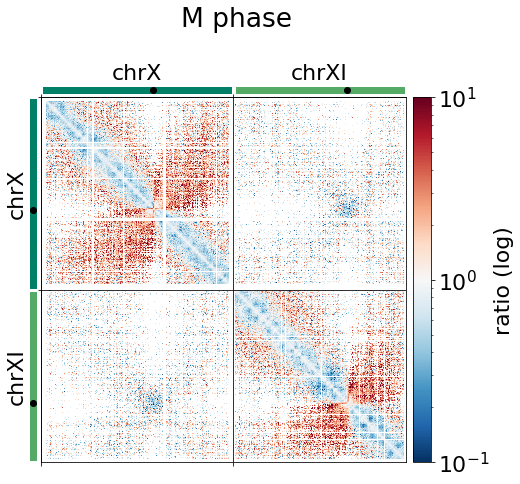

In [63]:
fig, ax = plt.subplots(
        figsize=(7, 7),
        ncols=1
    )

font_size = 22
font = {'size': font_size}
plt.rc('font', **font)

if ratio:
    vmin = 0.1
    vmax = 10
    colormap = 'RdBu_r'
    cbar_label = 'ratio (log)'
else:
    vmin = 0.00001
    vmax = 0.1
    colormap = 'fall'
    cbar_label = 'contact frequency (log)'

im = ax.matshow(
    hmap,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap=colormap,
    extent=(start, end, end, start)
)

ax.set_xlim(start, end)
ax.set_ylim(start, end)
ax.invert_yaxis()

if region[0] == region[1]:
    format_chrom_labels(ax, chrom_names=chrom_names, chrom_positions=chrom_positions, centromeres={cen.chrom: cen.mid // bin_size for cen in centromeres.itertuples()}, plot_labels=True)
    format_ticks(ax=ax, x=True, y=False, rotate=True, unit='Mb')
    #bp_formatter = FuncFormatter(lambda x, pos: '{0:g} kb'.format(x * bin_size // 1000))
    #ax.yaxis.set_major_formatter(bp_formatter)
    #ax.xaxis.set_major_formatter(bp_formatter)
    #ax.xaxis.tick_bottom()
else:
    format_chrom_labels(ax, chrom_names=chrom_names, chrom_positions=chrom_positions, centromeres={cen.chrom: cen.mid // bin_size for cen in centromeres.itertuples()}, plot_labels=True)
    ax.set_xticks([pos[0] for pos in chrom_positions])
    ax.set_yticks([pos[0] for pos in chrom_positions])
    ax.grid(color='black')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label=cbar_label)

fig.suptitle(title)
fig.subplots_adjust(top=0.5)

plt.tight_layout()
#plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()